In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/big-mart-sales-prediction-datasets'):
      for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import datetime as dt

In [8]:
bigmart_df = pd.read_csv(r"C:\Users\KIIT\Bigmart sales prediction\archive\train.csv")

In [9]:
bigmart_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
bigmart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [11]:
bigmart_df.duplicated().any()

False

In [12]:
bigmart_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [13]:
per = bigmart_df.isnull().sum() * 100/len(bigmart_df)
print(per)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


In [14]:
bigmart_df["Item_Weight_mean"] =bigmart_df["Item_Weight"].fillna(bigmart_df["Item_Weight"].mean())

bigmart_df["Item_Weight_median"] =bigmart_df["Item_Weight"].fillna(bigmart_df["Item_Weight"].median())

In [15]:
print("original weight variance", bigmart_df["Item_Weight"].var())
print("mean weight  variance", bigmart_df["Item_Weight_mean"].var())
print("median weight variance", bigmart_df["Item_Weight_median"].var())

original weight variance 21.561688259836558
mean weight  variance 17.86012173506058
median weight variance 17.869561454073647


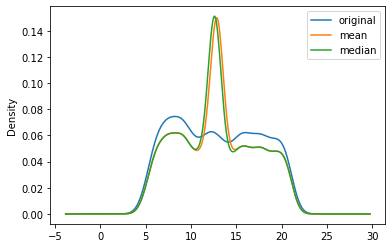

In [17]:
bigmart_df["Item_Weight"].plot(kind="kde", label = "original")

bigmart_df["Item_Weight_mean"].plot(kind="kde", label = "mean")
bigmart_df["Item_Weight_median"].plot(kind="kde", label = "median")

plt.legend()
plt.show()

In [18]:
bigmart_df["Item_Weight_interpolate"] =bigmart_df["Item_Weight"].interpolate(method = "linear")

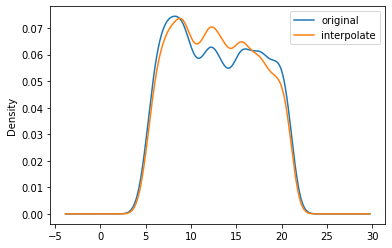

In [19]:
bigmart_df["Item_Weight"].plot(kind="kde", label = "original")

bigmart_df["Item_Weight_interpolate"].plot(kind="kde", label = "interpolate")


plt.legend()
plt.show()

In [20]:
from sklearn.impute import KNNImputer

knn = KNNImputer(n_neighbors = 10, weights ="distance")

bigmart_df["knn_imputer"] = knn.fit_transform(bigmart_df[["Item_Weight"]]).ravel()

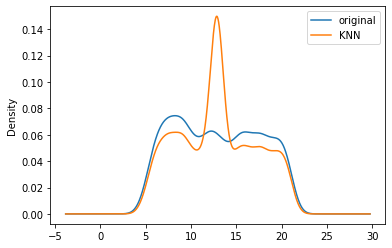

In [21]:
bigmart_df["Item_Weight"].plot(kind="kde", label = "original")

bigmart_df["knn_imputer"] .plot(kind="kde", label = "KNN")


plt.legend()
plt.show()

In [22]:
bigmart_df["Item_Weight"].fillna(bigmart_df["Item_Weight"].interpolate(method = "linear"), inplace = True)

In [23]:
bigmart_df.sample()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_mean,Item_Weight_median,Item_Weight_interpolate,knn_imputer
112,FDW39,8.96,Regular,0.064625,Meat,176.937,OUT019,1985,Small,Tier 1,Grocery Store,176.437,12.857645,12.6,8.96,12.857645


In [24]:
bigmart_df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Weight_mean                0
Item_Weight_median              0
Item_Weight_interpolate         0
knn_imputer                     0
dtype: int64

In [25]:
mode_of_outlet_size = bigmart_df.pivot_table(values = 'Outlet_Size',columns ='Outlet_Type', aggfunc =(lambda x: x.mode()[0]))

In [26]:
mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [27]:
missing_value = bigmart_df['Outlet_Size'].isnull()

In [28]:
bigmart_df.loc[missing_value, 'Outlet_Size'] = bigmart_df.loc[missing_value, 'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])

In [29]:
bigmart_df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Weight_mean             0
Item_Weight_median           0
Item_Weight_interpolate      0
knn_imputer                  0
dtype: int64

In [30]:
bigmart_df["Outlet_Size"].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [31]:
bigmart_df["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [32]:
bigmart_df.replace({"Item_Fat_Content": {"LF" :"Low Fat", "low fat" : "Low Fat", "reg": "Regular" }}, inplace =True)

In [33]:
bigmart_df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [34]:
bigmart_df["Item_Visibility"].value_counts()

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

In [35]:
bigmart_df["Item_Visibility_interpolate"] =bigmart_df["Item_Visibility"].replace(0,np.nan).interpolate(method = "linear")

In [37]:
bigmart_df["Item_Visibility_interpolate"].value_counts()

0.076975    3
0.044024    2
0.040912    2
0.076856    2
0.078759    2
           ..
0.021011    1
0.099189    1
0.076866    1
0.014116    1
0.044878    1
Name: Item_Visibility_interpolate, Length: 8405, dtype: int64

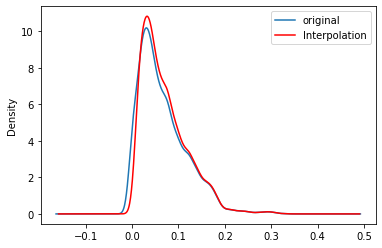

In [38]:
bigmart_df["Item_Visibility"].plot(kind="kde", label = "original")

bigmart_df["Item_Visibility_interpolate"] .plot(kind="kde",color ="red", label = "Interpolation")


plt.legend()
plt.show()


In [40]:
bigmart_df["Item_Identifier"].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [41]:
bigmart_df["Item_Identifier"] = bigmart_df["Item_Identifier"].apply(lambda x : x[:2])

In [42]:
bigmart_df["Item_Identifier"].value_counts()

FD    6125
NC    1599
DR     799
Name: Item_Identifier, dtype: int64

In [43]:
bigmart_df["Outlet_Establishment_Year"].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [44]:
current_year = dt.datetime.today().year

current_year

2024

In [45]:
bigmart_df["Outlet_age"] = current_year - bigmart_df["Outlet_Establishment_Year"]

In [46]:
bigmart_df.head(1)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_mean,Item_Weight_median,Item_Weight_interpolate,knn_imputer,Item_Visibility_interpolate,Outlet_age
0,FD,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138,9.3,9.3,9.3,9.3,0.016047,25


In [47]:
bigmart_df.drop([ "Outlet_Establishment_Year","Item_Visibility","Item_Weight_mean","Item_Weight_median","Item_Weight_interpolate","knn_imputer"], axis = 1, inplace = True)

In [48]:
sns.set()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_25800\880364946.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bigmart_df["Item_Weight"])


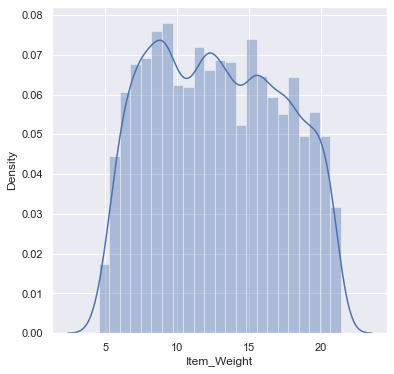

In [49]:
plt.figure(figsize =(6,6))
sns.distplot(bigmart_df["Item_Weight"])
plt.show()

<Figure size 432x432 with 0 Axes>

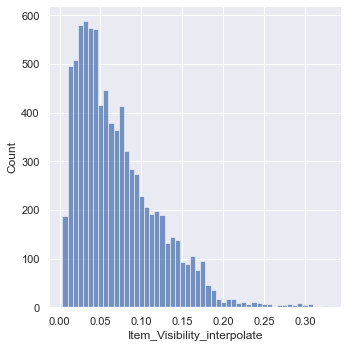

In [50]:
plt.figure(figsize =(6,6))
sns.displot(bigmart_df["Item_Visibility_interpolate"])
plt.show()

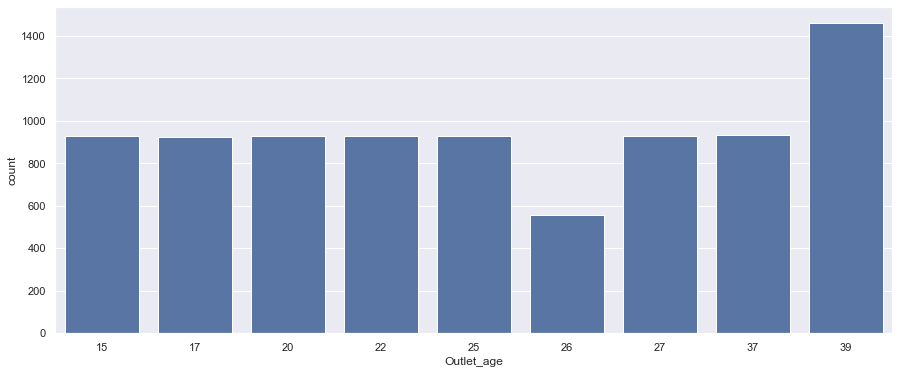

In [51]:
plt.figure(figsize=(15,6))
sns.countplot(data= bigmart_df, x="Outlet_age" )
plt.show()

<Figure size 1800x432 with 0 Axes>

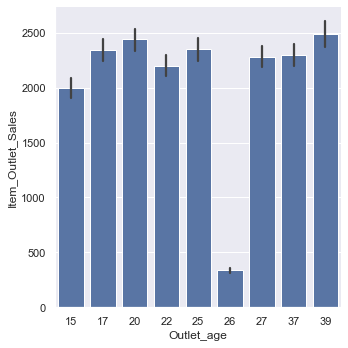

In [52]:
plt.figure(figsize=(25,6))
sns.catplot(data= bigmart_df, x="Outlet_age", y="Item_Outlet_Sales", kind="bar")
plt.show()

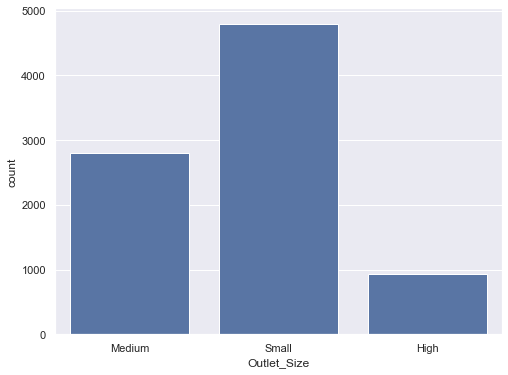

In [53]:
plt.figure(figsize=(8,6))
sns.countplot(data= bigmart_df, x="Outlet_Size")
plt.show()

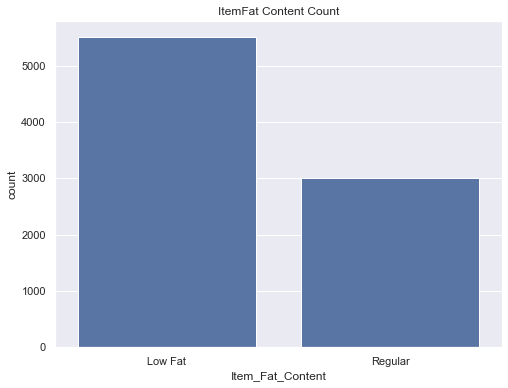

In [54]:
plt.figure(figsize=(8,6))
sns.countplot(data= bigmart_df, x="Item_Fat_Content")
plt.title("ItemFat Content Count")
plt.show()


In [55]:
coder = LabelEncoder()
bigmart_df["Item_Identifier"] = coder.fit_transform(bigmart_df["Item_Identifier"])
bigmart_df["Item_Fat_Content"] = coder.fit_transform(bigmart_df["Item_Fat_Content"])
bigmart_df["Item_Type"] = coder.fit_transform(bigmart_df["Item_Type"])
bigmart_df["Outlet_Identifier"] = coder.fit_transform(bigmart_df["Outlet_Identifier"])
bigmart_df["Outlet_Size"] = coder.fit_transform(bigmart_df["Outlet_Size"])
bigmart_df["Outlet_Location_Type"] = coder.fit_transform(bigmart_df["Outlet_Location_Type"])
bigmart_df["Outlet_Type"] = coder.fit_transform(bigmart_df["Outlet_Type"])

In [56]:
bigmart_df.corr()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_interpolate,Outlet_age
Item_Identifier,1.000000,0.056939,-0.166111,0.007456,0.032517,-0.009730,-0.001276,0.007661,0.001136,0.011236,-0.046347,0.008551
Item_Weight,0.056939,1.000000,-0.015030,0.028262,0.024839,-0.006937,-0.014556,0.005960,-0.000858,0.014536,-0.012096,-0.001220
Item_Fat_Content,-0.166111,-0.015030,1.000000,-0.139434,0.006063,0.000764,-0.001262,-0.001598,0.002199,0.018719,0.048694,-0.003151
Item_Type,0.007456,0.028262,-0.139434,1.000000,0.032651,0.001656,-0.000218,0.003084,0.003053,0.017048,-0.033981,-0.004970
Item_MRP,0.032517,0.024839,0.006063,0.032651,1.000000,0.003319,0.000872,0.000232,-0.001975,0.567574,-0.006544,-0.005020
Outlet_Identifier,-0.009730,-0.006937,0.000764,0.001656,0.003319,1.000000,0.260272,-0.716176,0.099873,0.162325,-0.102528,-0.079035
Outlet_Size,-0.001276,-0.014556,-0.001262,-0.000218,0.000872,0.260272,1.000000,-0.480075,-0.401373,-0.162753,0.098213,-0.425534
Outlet_Location_Type,0.007661,0.005960,-0.001598,0.003084,0.000232,-0.716176,-0.480075,1.000000,0.467219,0.089367,-0.030813,0.089216
Outlet_Type,0.001136,-0.000858,0.002199,0.003053,-0.001975,0.099873,-0.401373,0.467219,1.000000,0.401522,-0.179788,0.122304
Item_Outlet_Sales,0.011236,0.014536,0.018719,0.017048,0.567574,0.162325,-0.162753,0.089367,0.401522,1.000000,-0.133874,0.049135


In [57]:
bigmart_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_interpolate,Outlet_age
0,1,9.30,0,4,249.8092,9,1,0,1,3735.1380,0.016047,25
1,0,5.92,1,14,48.2692,3,1,2,2,443.4228,0.019278,15
2,1,17.50,0,10,141.6180,9,1,0,1,2097.2700,0.016760,25
3,1,19.20,1,6,182.0950,0,2,2,0,732.3800,0.015755,26
4,2,8.93,0,9,53.8614,1,0,2,1,994.7052,0.014751,37


In [58]:
X = bigmart_df.drop(columns = "Item_Outlet_Sales", axis = 1)
y = bigmart_df["Item_Outlet_Sales"]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state =2)

In [60]:
xg = XGBRegressor()
xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
training_data_prediction = xg.predict(X_train)

In [62]:
r2_train = metrics.r2_score(y_train, training_data_prediction)

print("R-squared value for train data =", r2_train)

R-squared value for train data = 0.8743719828705219


In [63]:
testing_data_prediction = xg.predict(X_test)

In [64]:
r2_test = metrics.r2_score(y_test, testing_data_prediction)

print("R-squared value for test_data =", r2_test)

R-squared value for test_data = 0.5109242182102149


In [65]:
mean_absolute_error(y_train, training_data_prediction)

436.37837256541997

In [66]:
mae= mean_absolute_error(y_test, testing_data_prediction)
print(mae)

865.5705518787743


In [67]:
pred = xg.predict(np.array([[1,9.3,0,4,249.8092,9,1,0,1,0.016047301,25]]))

print(pred)

[4184.5493]


In [68]:
print(f"Sales value is in between {pred-865.57} and {pred+865.57}")

Sales value is in between [3318.9792] and [5050.119]


In [69]:
bigmart_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Visibility_interpolate,Outlet_age
0,1,9.300,0,4,249.8092,9,1,0,1,3735.1380,0.016047,25
1,0,5.920,1,14,48.2692,3,1,2,2,443.4228,0.019278,15
2,1,17.500,0,10,141.6180,9,1,0,1,2097.2700,0.016760,25
3,1,19.200,1,6,182.0950,0,2,2,0,732.3800,0.015755,26
4,2,8.930,0,9,53.8614,1,0,2,1,994.7052,0.014751,37
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,1,6.865,0,13,214.5218,1,0,2,1,2778.3834,0.056783,37
8519,1,8.380,1,0,108.1570,7,2,1,1,549.2850,0.046982,22
8520,2,10.600,0,8,85.1224,6,2,1,1,1193.1136,0.035186,20
8521,1,7.210,1,13,103.1332,3,1,2,2,1845.5976,0.145221,15


In [70]:
print(f"Sales value is in between {pred-865.57} and {pred+865.57}")

Sales value is in between [3318.9792] and [5050.119]
